In [24]:
import pandas as pd
import numpy as np
import os
import pathlib
import warnings
# probml_utils not available - using alternative visualization
# import probml_utils.pgmpy_utils as pgm
from pgmpy.estimators import MaximumLikelihoodEstimator
from collections.abc import Iterable, Mapping, Sequence
import pgmpy
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import HillClimbSearch, ExhaustiveSearch, BIC, AIC
from pgmpy.estimators.StructureScore import K2, BDeu
from causalgraphicalmodels import CausalGraphicalModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
pd.options.display.max_rows = 500
pd.options.display.max_columns = 300
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import HillClimbSearch, ExhaustiveSearch, PC, TreeSearch, BIC, MaximumLikelihoodEstimator
from pgmpy.metrics import structure_score
from sklearn.model_selection import train_test_split
from pgmpy.sampling import BayesianModelSampling
from pgmpy.metrics import structure_score
from scipy.stats import chi2_contingency

import networkx as nx
from matplotlib import pyplot as plt
    
warnings.filterwarnings("ignore")

diagnosis_data = pd.read_csv("../datasets/C3DC Diagnosis.csv")
participant_data = pd.read_csv("../datasets/C3DC Participants.csv")
treatment_data = pd.read_csv("../datasets/C3DC Treatment Data.csv")
treatment_response_data = pd.read_csv("../datasets/C3DC Treatment Response.csv")
survival_data = pd.read_csv("../datasets/C3DC Survival.csv")

In [9]:
# ---------------------------------------------------------
# Step 1: Target Variable (Classification) - CNS Tumor Flag
# ---------------------------------------------------------
cns_codes = ['C70', 'C71', 'C72']

def check_cns(site):
    if pd.isna(site):
        return 0
    for code in cns_codes:
        if code in str(site):
            return 1
    return 0

diagnosis_data['is_cns_tumor'] = diagnosis_data['Anatomic Site'].apply(check_cns)
# Aggregate per participant (Max: if any diagnosis is CNS, label as 1)
target_df = diagnosis_data.groupby('Participant ID')['is_cns_tumor'].max().reset_index()

# ---------------------------------------------------------
# Step 2: Feature - Age (Numeric)
# ---------------------------------------------------------
diagnosis_data['Age_numeric'] = pd.to_numeric(diagnosis_data['Age at Diagnosis (days)'], errors='coerce')
# Take the minimum age (age at first diagnosis)
age_df = diagnosis_data.groupby('Participant ID')['Age_numeric'].min().reset_index()
age_df.rename(columns={'Age_numeric': 'Age_at_Diagnosis_Days'}, inplace=True)

# ---------------------------------------------------------
# Step 4: Survival Data Processing (New Step!)
# ---------------------------------------------------------
# Convert Age at Last Contact to numeric
survival_data['Age_Last_Contact'] = pd.to_numeric(survival_data['Age at Last Known Survival Status'], errors='coerce')

# Define Event (1=Dead, 0=Alive/Censored)
# "Dead" is the event. "Alive", "Not Reported", "Unknown" are censored (0).
survival_data['Event_Status'] = survival_data['Last Known Survival Status'].apply(lambda x: 1 if x == 'Dead' else 0)
# Select only necessary columns to avoid duplicates
survival_clean = survival_data[['Participant ID', 'Age_Last_Contact', 'Event_Status']].drop_duplicates('Participant ID')


#print("Survival Columns", survival_clean.columns.tolist())
#print("Target Columns", target_df.columns.tolist())
#print("Age Columns", age_df.columns.tolist())
#print("Participant Columns", participant_data.columns.tolist())

# ---------------------------------------------------------
# Step 5: Merging All Data
# ---------------------------------------------------------
df_merged = pd.merge(treatment_data, target_df, on='Participant ID', how='left')
df_merged = pd.merge(df_merged, age_df, on='Participant ID', how='left')
df_merged = pd.merge(df_merged, survival_clean, on='Participant ID', how='left') # <--- Merge Survival
df_merged = pd.merge(df_merged, participant_data, on='Participant ID', how='left')

# ---------------------------------------------------------
# Step 6: Final Preprocessing & Calculations
# ---------------------------------------------------------

# 1. Filter: Keep only rows where 'is_cns_tumor' is defined
df_merged = df_merged.dropna(subset=['is_cns_tumor'])

# 2. Impute Missing Age (Median) & Add Flag
median_age = df_merged['Age_at_Diagnosis_Days'].median()
df_merged['Age_missing_flag'] = df_merged['Age_at_Diagnosis_Days'].apply(lambda x: 1 if pd.isna(x) else 0)
df_merged['Age_at_Diagnosis_Days'] = df_merged['Age_at_Diagnosis_Days'].fillna(median_age)

# 4. Handle Categorical Missings (Race, Sex)
categorical_cols = ['Race', 'Sex at Birth']

#print(df_merged.head())
for col in categorical_cols:
    df_merged[col] = df_merged[col].fillna('Unknown')
    df_merged[col] = df_merged[col].replace('Not Reported', 'Unknown')

# 5. Calculate Survival Time (Time-to-Event)
# Survival Time = Age at Last Contact - Age at Diagnosis
df_merged['Survival_Time_Days'] = df_merged['Age_Last_Contact'] - df_merged['Age_at_Diagnosis_Days']

THRESHOLD = 730  # 2 years in days

# Target: 1 if patient died within threshold, 0 otherwise
df_merged['Target'] = np.where(
    (df_merged['Event_Status'] == 1) & (df_merged['Survival_Time_Days'] < THRESHOLD),
    1,
    0
)

df_final_bayeswork = df_merged.copy()
#print("final columns check:", df_final_bayeswork.columns.tolist())
df_final_bayeswork = df_final_bayeswork.drop(columns=["Study ID_x"])
df_final_bayeswork.rename(columns={"Study ID_y": "Study_ID"}, inplace=True)
print("Final Columns:", df_final_bayeswork.columns.tolist())

Final Columns: ['Participant ID', 'Treatment ID', 'Age at Treatment Start', 'Age at Treatment End', 'Treatment Type', 'Treatment Agent', 'is_cns_tumor', 'Age_at_Diagnosis_Days', 'Age_Last_Contact', 'Event_Status', 'Race', 'Sex at Birth', 'Study_ID', 'Age_missing_flag', 'Survival_Time_Days', 'Target']


In [10]:
print("Final Dataset Overall Summary")
df_final_bayeswork.describe(include='all')

df_final_bayeswork['Target'].value_counts() 


Final Dataset Overall Summary


Target
0    2553
1     319
Name: count, dtype: int64

In [11]:
print("Data Info:")
df_final_bayeswork.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 2872 entries, 0 to 2871
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Participant ID          2872 non-null   object 
 1   Treatment ID            2872 non-null   object 
 2   Age at Treatment Start  2872 non-null   object 
 3   Age at Treatment End    2872 non-null   object 
 4   Treatment Type          2872 non-null   object 
 5   Treatment Agent         2872 non-null   object 
 6   is_cns_tumor            2872 non-null   float64
 7   Age_at_Diagnosis_Days   2872 non-null   float64
 8   Age_Last_Contact        1958 non-null   float64
 9   Event_Status            2817 non-null   float64
 10  Race                    2872 non-null   object 
 11  Sex at Birth            2872 non-null   object 
 12  Study_ID                2872 non-null   object 
 13  Age_missing_flag        2872 non-null   int64  
 14  Survival_Time_Days      1958 non-n

In [12]:
for col in [x for x in df_final_bayeswork.drop(columns=['Participant ID', "Treatment ID", "Study_ID"], axis=1).columns if df_final_bayeswork.drop(columns=['Participant ID', "Treatment ID", "Study_ID"], axis=1)[x].dtype == 'object']:
    print(df_final_bayeswork[col].value_counts())

Age at Treatment Start
Not Reported    2872
Name: count, dtype: int64
Age at Treatment End
Not Reported    2872
Name: count, dtype: int64
Treatment Type
Surgical Procedure                      1512
Pharmacotherapy                          349
Radiation Therapy                        293
Chemotherapy                             274
Proton Beam Radiation Therapy            208
Photon Beam Radiation Therapy             69
Autologous Stem Cell Transplantation      51
Unknown                                   50
Stem Cell Transplant                      38
Immunotherapy                             19
Electron Beam Radiation Therapy            5
Targeted Molecular Therapy                 2
Cellular Therapy                           2
Name: count, dtype: int64
Treatment Agent
Not Reported                                                    2585
Vincristine                                                       48
Carboplatin                                                       37
Temozolomide 

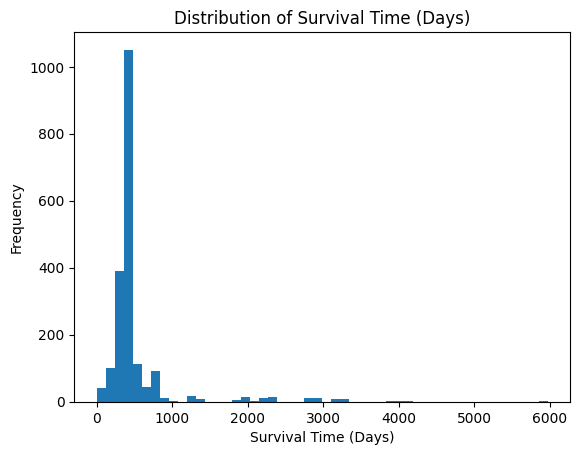

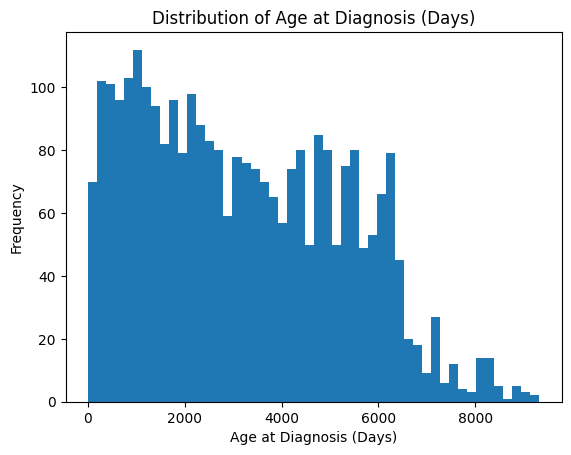

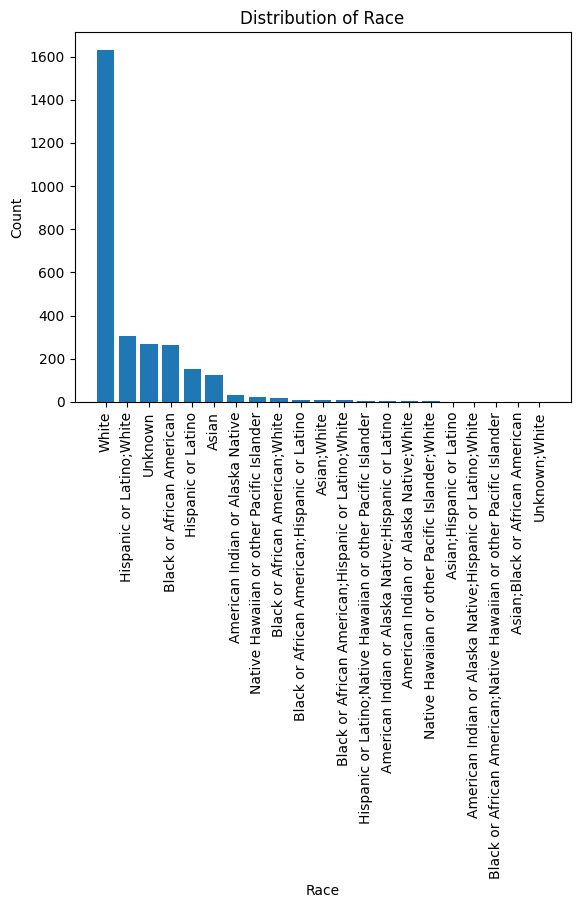

In [13]:
plt.hist(df_final_bayeswork['Survival_Time_Days'].dropna(), bins=50)
plt.xlabel('Survival Time (Days)')
plt.ylabel("Frequency")
plt.title("Distribution of Survival Time (Days)")
plt.show()


plt.hist(df_final_bayeswork['Age_at_Diagnosis_Days'].dropna(), bins=50)
plt.xlabel('Age at Diagnosis (Days)')
plt.ylabel("Frequency")
plt.title("Distribution of Age at Diagnosis (Days)")
plt.show()


plt.bar(df_final_bayeswork['Race'].value_counts().index, df_final_bayeswork['Race'].value_counts())
plt.xticks(rotation=90)
plt.xlabel("Race")
plt.ylabel("Count")
plt.title("Distribution of Race")
plt.show()

In [16]:
bayes_net_data = df_final_bayeswork.drop(columns=['Participant ID', "Treatment ID", "Study_ID", "Age at Treatment Start", "Age at Treatment End", "Age_missing_flag", "Event_Status"], axis=1)

numeric_cols = ['Age_at_Diagnosis_Days', 'Survival_Time_Days', 'Age_Last_Contact']
for col in numeric_cols:
    if col in bayes_net_data.columns:
        bayes_net_data[col] = pd.to_numeric(bayes_net_data[col], errors='coerce')

bayes_net_data['Age_Group'] = pd.cut(
    bayes_net_data['Age_at_Diagnosis_Days'], 
    bins=[0, 365, 1825, 5475, 10950, float('inf')],  # 0-1yr, 1-5yr, 5-15yr, 15-30yr, 30+yr
    labels=['Infant', 'Toddler', 'Child', 'Adolescent', 'Adult']
)

bayes_net_data['Survival_Group'] = pd.cut(
    bayes_net_data['Survival_Time_Days'],
    bins=[-float('inf'), 0, 365, 1825, float('inf')],  # negative (error), <1yr, 1-5yr, 5+yr
    labels=['Negative', 'Short', 'Medium', 'Long']
)

bayes_net_data['Age_Last_Contact_Group'] = pd.cut(
    bayes_net_data['Age_Last_Contact'],
    bins=[0, 1825, 5475, 10950, float('inf')],  # 0-5yr, 5-15yr, 15-30yr, 30+yr
    labels=['Young', 'Child', 'Teen', 'Adult']
)

bayes_net_data = bayes_net_data.drop(columns=['Age_at_Diagnosis_Days', 'Survival_Time_Days', 'Age_Last_Contact'])

race_counts = bayes_net_data['Race'].value_counts()

threshold = len(bayes_net_data) * 0.05
bayes_net_data['Race'] = bayes_net_data['Race'].apply(
    lambda x: x if race_counts.get(x, 0) >= threshold else 'Other'
)


for col in bayes_net_data.columns:
    bayes_net_data[col] = bayes_net_data[col].astype(str)

bayes_net_data = bayes_net_data.replace('nan', 'Unknown')
bayes_net_data = bayes_net_data.fillna('Unknown')

bayes_net_data.drop(columns=['is_cns_tumor'], inplace=True)

In [ ]:
print(f"\nTarget distribution:")
print(bayes_net_data['Target'].value_counts())

associations = []
for col in bayes_net_data.columns:
    if col != 'Target':
        # Create contingency table
        contingency_table = pd.crosstab(bayes_net_data[col], bayes_net_data['Target'])
        
        # Perform chi-square test
        try:
            chi2, p_value, dof, expected = chi2_contingency(contingency_table)
            
            associations.append({
                'Variable': col,
                'Chi2': chi2,
                'P-value': p_value,
                'DOF': dof,
                'Significant': 'Yes' if p_value < 0.05 else 'No'
            })
            
            # Only print significant ones during the loop for brevity
            if p_value < 0.01:  # Very significant
                print(f"\n{col}:")
                print(f"  Chi-square: {chi2:.4f}, P-value: {p_value:.6f}, DOF: {dof}")
        except Exception as e:
            print(f"\n{col}: ERROR - {e}")
            associations.append({
                'Variable': col,
                'Chi2': np.nan,
                'P-value': np.nan,
                'DOF': np.nan,
                'Significant': 'Error'
            })

# Sort by p-value
associations_df = pd.DataFrame(associations).sort_values('P-value')

print("\n" + "="*80)
print("TOP 20 Variables ranked by association with Target (Poor Prognosis):")
print("="*80)
print(associations_df.head(20).to_string(index=False))

# Show variables that are significantly associated
sig_vars = associations_df[associations_df['Significant'] == 'Yes']['Variable'].tolist()
print(f"\nSignificantly associated variables (p < 0.05): {len(sig_vars)}")

# Categorize significant variables
diagnosis_cols = [v for v in sig_vars if any(keyword in v.lower() for keyword in ['diagnosis', 'tumor', 'disease', 'grade', 'stage', 'staging'])]
response_cols = [v for v in sig_vars if any(keyword in v.lower() for keyword in ['response', 'category', 'system'])]
survival_cols = [v for v in sig_vars if any(keyword in v.lower() for keyword in ['survival', 'event', 'cause'])]
treatment_cols = [v for v in sig_vars if any(keyword in v.lower() for keyword in ['treatment', 'agent'])]
demographic_cols = [v for v in sig_vars if any(keyword in v.lower() for keyword in ['age', 'race', 'sex'])]

print(f"\n{'='*80}")
print("SIGNIFICANT FEATURES BY CATEGORY:")
print(f"{'='*80}")

if diagnosis_cols:
    print(f"\nDIAGNOSIS features ({len(diagnosis_cols)}):")
    for col in diagnosis_cols[:10]:
        p_val = associations_df[associations_df['Variable'] == col]['P-value'].values[0]
        chi2_val = associations_df[associations_df['Variable'] == col]['Chi2'].values[0]
        print(f"  - {col}: Chi2={chi2_val:.2f}, p={p_val:.6f}")

if treatment_cols:
    print(f"\nTREATMENT features ({len(treatment_cols)}):")
    for col in treatment_cols[:10]:
        p_val = associations_df[associations_df['Variable'] == col]['P-value'].values[0]
        chi2_val = associations_df[associations_df['Variable'] == col]['Chi2'].values[0]
        print(f"  - {col}: Chi2={chi2_val:.2f}, p={p_val:.6f}")

if response_cols:
    print(f"\nTREATMENT RESPONSE features ({len(response_cols)}):")
    for col in response_cols[:10]:
        p_val = associations_df[associations_df['Variable'] == col]['P-value'].values[0]
        chi2_val = associations_df[associations_df['Variable'] == col]['Chi2'].values[0]
        print(f"  - {col}: Chi2={chi2_val:.2f}, p={p_val:.6f}")

if survival_cols:
    print(f"\nSURVIVAL features ({len(survival_cols)}):")
    for col in survival_cols[:10]:
        p_val = associations_df[associations_df['Variable'] == col]['P-value'].values[0]
        chi2_val = associations_df[associations_df['Variable'] == col]['Chi2'].values[0]
        print(f"  - {col}: Chi2={chi2_val:.2f}, p={p_val:.6f}")

if demographic_cols:
    print(f"\nDEMOGRAPHIC features ({len(demographic_cols)}):")
    for col in demographic_cols[:10]:
        p_val = associations_df[associations_df['Variable'] == col]['P-value'].values[0]
        chi2_val = associations_df[associations_df['Variable'] == col]['Chi2'].values[0]
        print(f"  - {col}: Chi2={chi2_val:.2f}, p={p_val:.6f}")

print(f"\n{'='*80}")
print(f"SUMMARY: {len(sig_vars)} total features significantly associated with poor prognosis")
print(f"{'='*80}")


Target distribution:
Target
0    2553
1     319
Name: count, dtype: int64

Treatment Type:
  Chi-square: 241.0983, P-value: 0.000000, DOF: 12

Treatment Agent:
  Chi-square: 204.3521, P-value: 0.000000, DOF: 24

Race:
  Chi-square: 49.7507, P-value: 0.000000, DOF: 5

Sex at Birth:
  Chi-square: 15.3395, P-value: 0.000090, DOF: 1

Survival_Group:
  Chi-square: 544.7381, P-value: 0.000000, DOF: 3

Age_Last_Contact_Group:
  Chi-square: 177.4289, P-value: 0.000000, DOF: 3

TOP 20 Variables ranked by association with Target (Poor Prognosis):
              Variable       Chi2       P-value  DOF Significant
        Survival_Group 544.738095 9.604056e-118    3         Yes
        Treatment Type 241.098259  9.796140e-45   12         Yes
Age_Last_Contact_Group 177.428865  3.167313e-38    3         Yes
       Treatment Agent 204.352142  1.499993e-30   24         Yes
                  Race  49.750667  1.558522e-09    5         Yes
          Sex at Birth  15.339457  8.982079e-05    1         Yes
 

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}


  0%|          | 0/1000 [00:00<?, ?it/s]

PC edges: 6
Constrained Hill Climb edges: 4
<class 'graphviz.graphs.Digraph'>


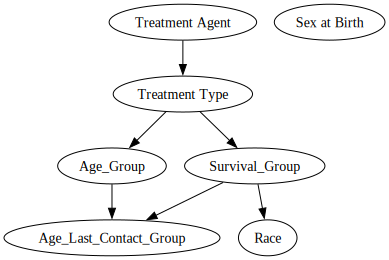

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}



Model: Constrained Hill Climb
Number of edges: 4
Number of nodes: 7


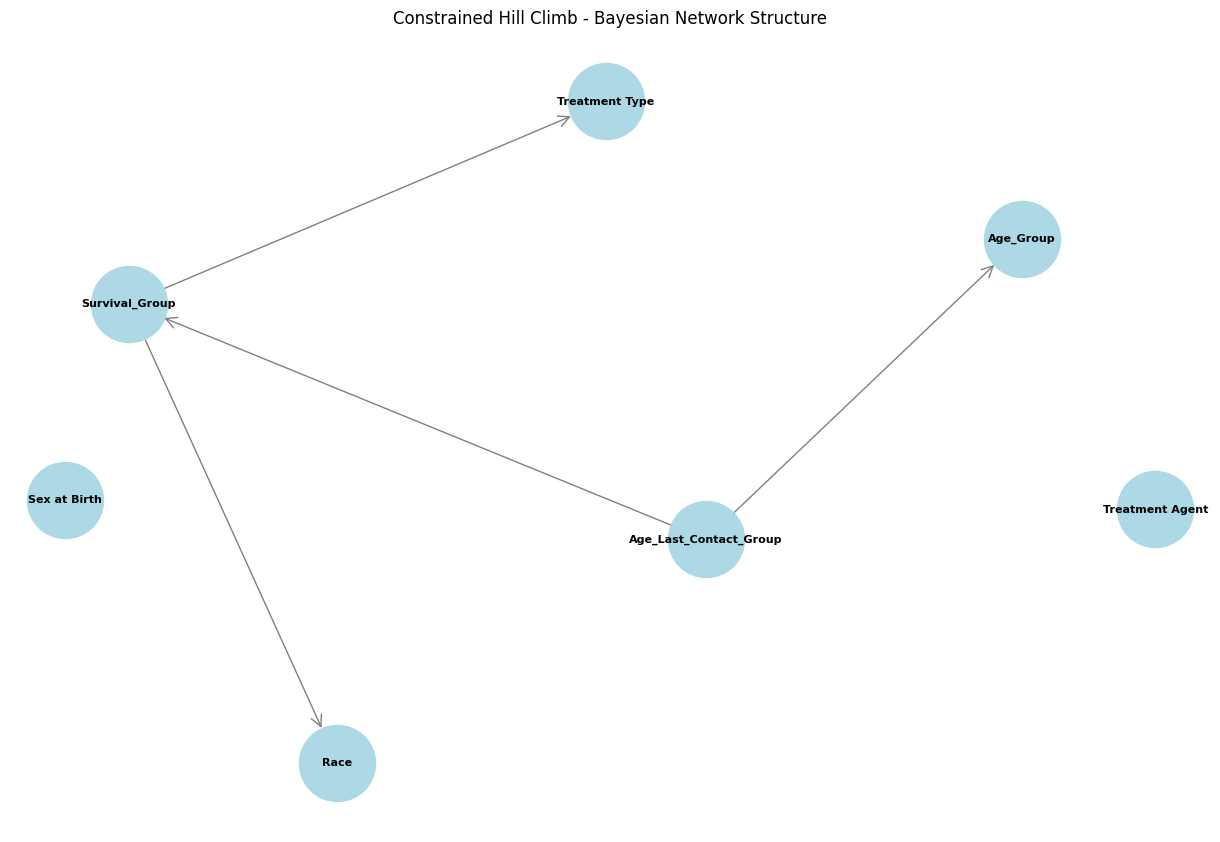

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}


BIC score: -19178.16
(Lower BIC is better)

Model: PC Algorithm
Number of edges: 6
Number of nodes: 7
(Converted PDAG to DAG)


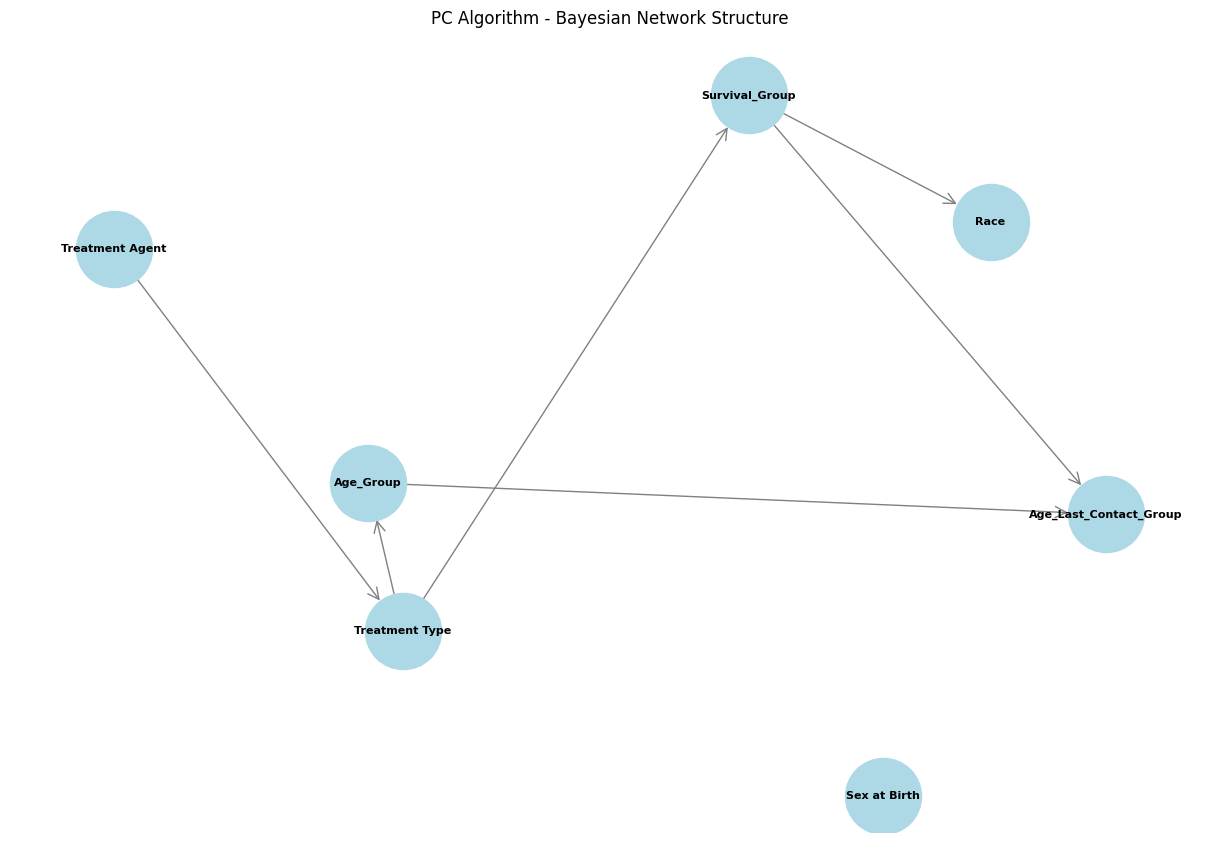

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}


BIC score: -19410.74
(Lower BIC is better)


In [ ]:
dataset_demo_bayes_net = bayes_net_data.drop(columns=[ "Target"], axis=1)
est_pc = PC(dataset_demo_bayes_net)
best_pc_model = est_pc.estimate()

# Method 2: Hill Climb with constraints\
est_hill_constrained = HillClimbSearch(dataset_demo_bayes_net)
best_hill_constrained_model = est_hill_constrained.estimate(
    scoring_method=BIC(dataset_demo_bayes_net),
    max_indegree=3,
    max_iter=1000
)

print("PC edges:", len(best_pc_model.edges()))
print("Constrained Hill Climb edges:", len(best_hill_constrained_model.edges()))

# Visualize PC model
model_pc = CausalGraphicalModel(nodes=best_pc_model.nodes(), edges=best_pc_model.edges())

dot = model_pc.draw()
print(type(dot))
display(dot)
dot.render(filename="../graphs_and_figures/pgm_participant_data_pc", format="pdf")


# Visualize Constrained Hill Climb model
model_constrained = CausalGraphicalModel(nodes=best_hill_constrained_model.nodes(), edges=best_hill_constrained_model.edges())

dot = model_constrained.draw()
#print(type(dot))
#display(dot)
dot.render(filename="../graphs_and_figures/pgm_participant_data_hill_constrained", format="pdf")

mymodels = [
    ("Constrained Hill Climb", best_hill_constrained_model),
    ("PC Algorithm", best_pc_model)
]

for name, model in mymodels:
    print(f"\n{'='*60}")
    print(f"Model: {name}")
    print(f"{'='*60}")
    print(f"Number of edges: {len(model.edges())}")
    print(f"Number of nodes: {len(model.nodes())}")
    
    if hasattr(model, 'to_dag'):
        model_dag = model.to_dag()
        print("(Converted PDAG to DAG)")
    else:
        model_dag = model
    
    network = DiscreteBayesianNetwork(model_dag)
    mle = MaximumLikelihoodEstimator(network, dataset_demo_bayes_net)
    
    for cpd in mle.get_parameters():
        network.add_cpds(cpd)
    
    # Alternative visualization without probml_utils

    
    # Convert to NetworkX DiGraph
    G = nx.DiGraph()
    G.add_nodes_from(network.nodes())
    G.add_edges_from(network.edges())
    
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42, k=2, iterations=50)
    nx.draw(G, pos, 
            with_labels=True, 
            node_color='lightblue', 
            node_size=3000, 
            font_size=8, 
            font_weight='bold',
            arrows=True,
            arrowsize=20,
            edge_color='gray',
            arrowstyle='->')
    plt.title(f"{name} - Bayesian Network Structure")
    plt.tight_layout()
    plt.show()
    
    bic_scorer = BIC(dataset_demo_bayes_net)
    bic_score = bic_scorer.score(model_dag)
    print(f'BIC score: {bic_score:.2f}')
    print(f"(Lower BIC is better)")


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Target': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Target': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Target': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Target': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}


  0%|          | 0/1000 [00:00<?, ?it/s]

PC edges: 6
Constrained Hill Climb edges: 6
<class 'graphviz.graphs.Digraph'>


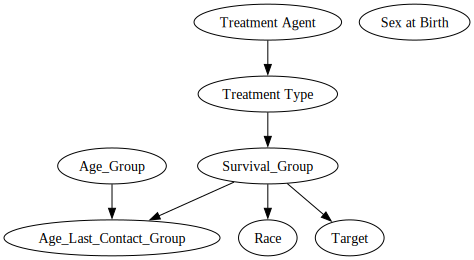

<class 'graphviz.graphs.Digraph'>


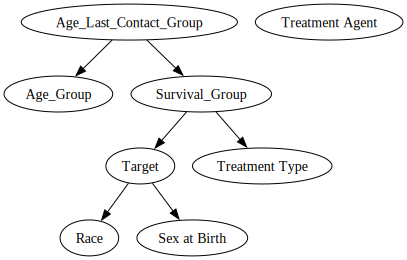

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Target': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}



Model: Constrained Hill Climb
Number of edges: 6
Number of nodes: 8


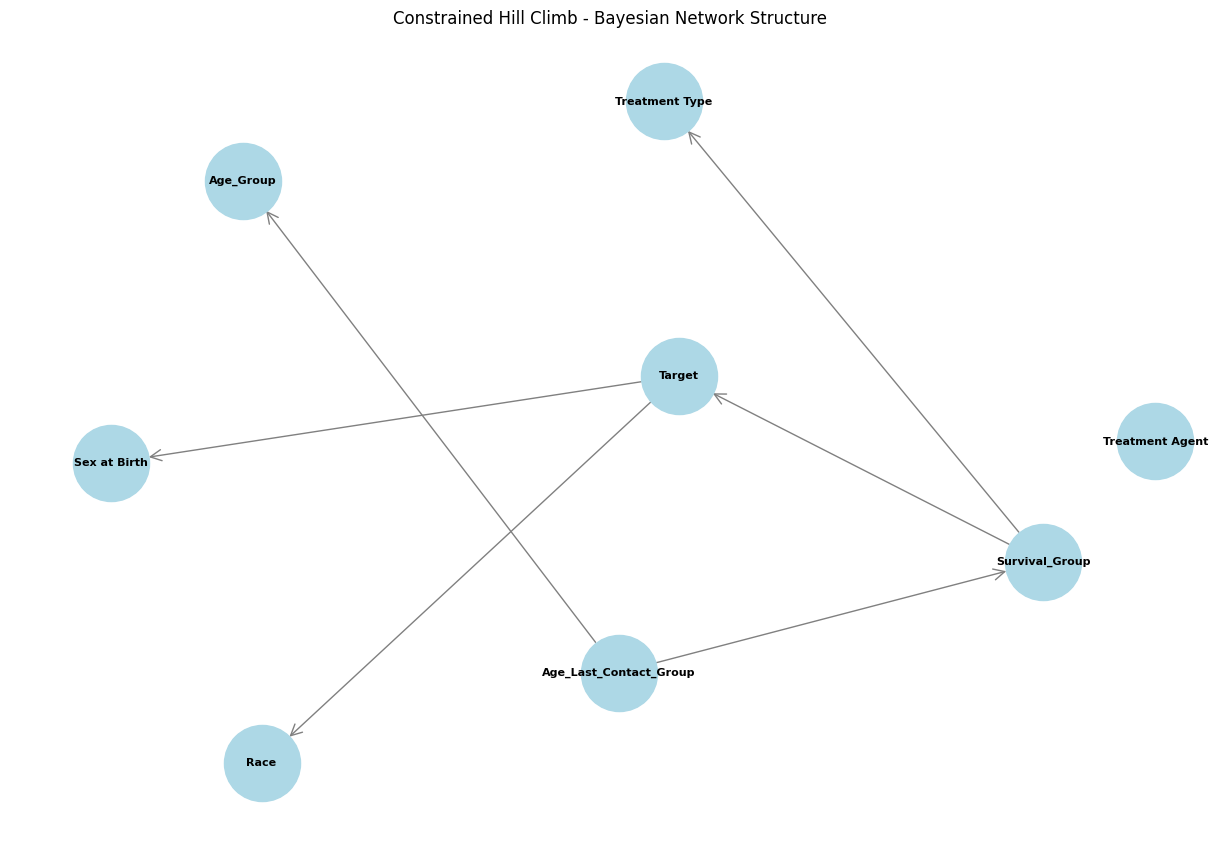

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Target': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Target': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}


BIC score: -19923.94
(Lower BIC is better)

Model: PC Algorithm
Number of edges: 6
Number of nodes: 8
(Converted PDAG to DAG)


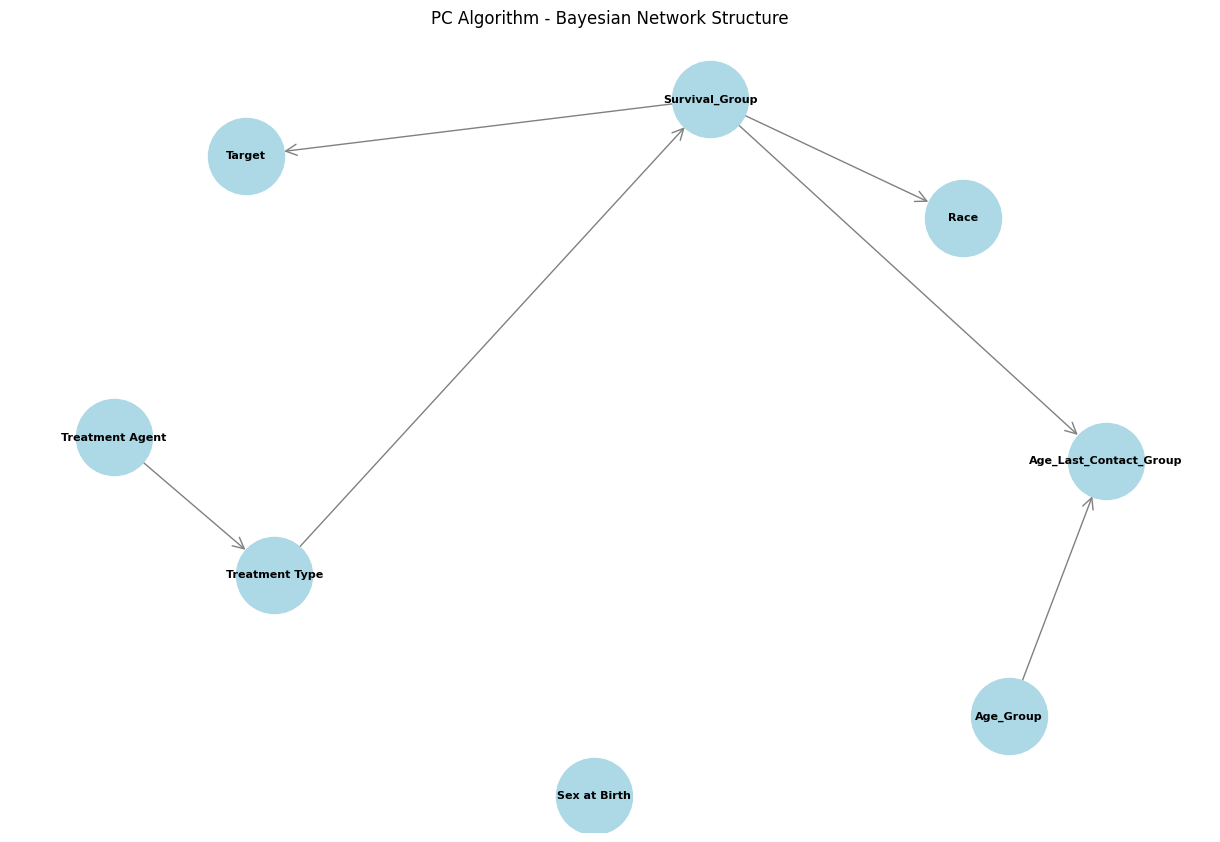

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Target': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}


BIC score: -20139.21
(Lower BIC is better)


In [ ]:
est_pc = PC(bayes_net_data)
best_pc_model = est_pc.estimate()

# Method 2: Hill Climb with constraints\
est_hill_constrained = HillClimbSearch(bayes_net_data)
best_hill_constrained_model = est_hill_constrained.estimate(
    scoring_method=BIC(bayes_net_data),
    max_indegree=3,
    max_iter=1000
)

print("PC edges:", len(best_pc_model.edges()))
print("Constrained Hill Climb edges:", len(best_hill_constrained_model.edges()))

# Visualize PC model
model_pc = CausalGraphicalModel(nodes=best_pc_model.nodes(), edges=best_pc_model.edges())

dot = model_pc.draw()
print(type(dot))
display(dot)
dot.render(filename="../graphs_and_figures/pgm_participant_data_pc_with_target", format="pdf")


# Visualize Constrained Hill Climb model
model_constrained = CausalGraphicalModel(nodes=best_hill_constrained_model.nodes(), edges=best_hill_constrained_model.edges())

dot = model_constrained.draw()
#print(type(dot))
#display(dot)
dot.render(filename="../graphs_and_figures/pgm_participant_data_hill_constrained_with_target", format="pdf")

mymodels = [
    ("Constrained Hill Climb", best_hill_constrained_model),
    ("PC Algorithm", best_pc_model)
]

for name, model in mymodels:
    print(f"\n{'='*60}")
    print(f"Model: {name}")
    print(f"{'='*60}")
    print(f"Number of edges: {len(model.edges())}")
    print(f"Number of nodes: {len(model.nodes())}")
    
    if hasattr(model, 'to_dag'):
        model_dag = model.to_dag()
        print("(Converted PDAG to DAG)")
    else:
        model_dag = model
    
    network = DiscreteBayesianNetwork(model_dag)
    mle = MaximumLikelihoodEstimator(network, bayes_net_data)
    
    for cpd in mle.get_parameters():
        network.add_cpds(cpd)
    
    # Alternative visualization without probml_utils
    import networkx as nx
    from matplotlib import pyplot as plt
    
    # Convert to NetworkX DiGraph
    G = nx.DiGraph()
    G.add_nodes_from(network.nodes())
    G.add_edges_from(network.edges())
    
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42, k=2, iterations=50)
    nx.draw(G, pos, 
            with_labels=True, 
            node_color='lightblue', 
            node_size=3000, 
            font_size=8, 
            font_weight='bold',
            arrows=True,
            arrowsize=20,
            edge_color='gray',
            arrowstyle='->')
    plt.title(f"{name} - Bayesian Network Structure")
    plt.tight_layout()
    plt.show()
    
    bic_scorer = BIC(bayes_net_data)
    bic_score = bic_scorer.score(model_dag)
    print(f'BIC score: {bic_score:.2f}')
    print(f"(Lower BIC is better)")
